In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Input,
    RandomFlip,
    RandomBrightness,
    RandomContrast,
    Rescaling,
    RandomRotation
)
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
seed = 1000
batch_size = 32
img_size=224

In [3]:
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)
plt.rc("image", cmap="magma")

# Dataset

A princípio, os dados serão separados apenas em treinamento e teste


In [4]:
X_train, X_test = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 923 files belonging to 2 classes.
Using 739 files for training.
Using 184 files for validation.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
X_train = X_train.cache().prefetch(buffer_size=AUTOTUNE)
X_test = X_test.cache().prefetch(buffer_size=AUTOTUNE)

# Modelo


In [6]:
data_augmentation = Sequential([
	RandomFlip(mode="horizontal", seed=seed),
	RandomBrightness(factor=0.2, seed=seed),
	RandomContrast(factor=0.2, seed=seed),
	RandomRotation(factor=0.2, seed=seed)
])

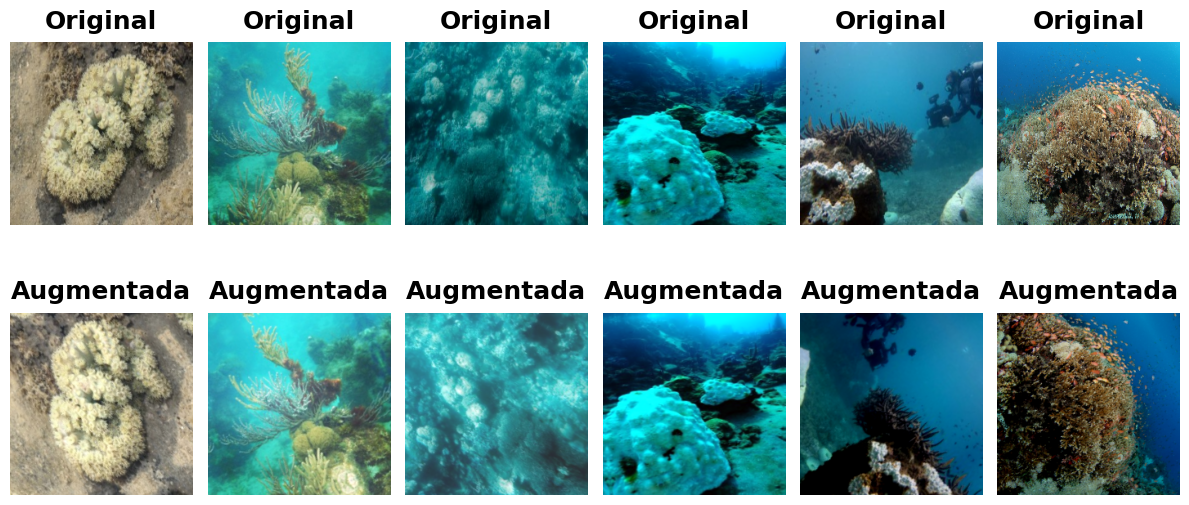

In [7]:
for images, labels in X_train.take(1):
    # Aplique o data augmentation
    augmented_images = data_augmentation(images)

    # Plote as imagens originais e aumentadas lado a lado
    plt.figure(figsize=(12, 6))
    for i in range(6):  # Mostra as 6 primeiras imagens do batch
        # Original
        plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        # Augmentada
        plt.subplot(2, 6, i + 7)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmentada")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break  # Mostra só o primeiro batch

In [8]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),
	data_augmentation,
 	Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=512, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=512, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=512, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=256, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[BinaryAccuracy()]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,722,497 (63.79 MB)

 Trainable params: 16,719,745 (63.78 MB)

 Non-trainable params: 2,752 (10.75 KB)

CallBacks


In [11]:
es = EarlyStopping(
    monitor="val_binary_accuracy", patience=40, restore_best_weights=True, verbose=1
)

rlr = ReduceLROnPlateau(monitor="val_binary_accuracy", factor=0.2, patience=30, verbose=True)

cp = ModelCheckpoint(
    "./checkpoint/cnn-7/checkpoint.model.keras",
    monitor="val_binary_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

In [12]:
history = model.fit(
    X_train,
    validation_data=X_test,
    epochs=200,
    callbacks=[es, rlr, cp],
)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6150 - loss: 2.8099
Epoch 1: val_binary_accuracy improved from -inf to 0.51087, saving model to ./checkpoint/cnn-7/checkpoint.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - binary_accuracy: 0.6161 - loss: 2.8028 - val_binary_accuracy: 0.5109 - val_loss: 2.0879 - learning_rate: 0.0010
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.5827 - loss: 2.6928
Epoch 2: val_binary_accuracy improved from 0.51087 to 0.56522, saving model to ./checkpoint/cnn-7/checkpoint.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - binary_accuracy: 0.5845 - loss: 2.6791 - val_binary_accuracy: 0.5652 - val_loss: 1.7988 - learning_rate: 0.0010
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6210 - loss: 2.2224
Epoch 3: val_binary_accuracy improved from 0.56522 to 0.68478, saving model to ./checkpoint/cnn-7/checkpoint.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - binary_accuracy: 0.6

# Resultados


In [13]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_bool = (y_pred > 0.5).astype(int)

y_test = np.concatenate([y for x, y in X_test], axis=0)

print(classification_report(y_test, y_pred_bool))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.74      0.79        91
         1.0       0.77      0.88      0.82        93

    accuracy                           0.81       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.81      0.81       184



<Axes: >

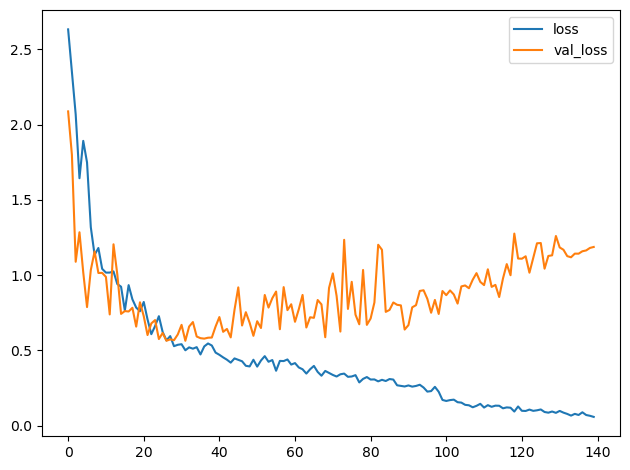

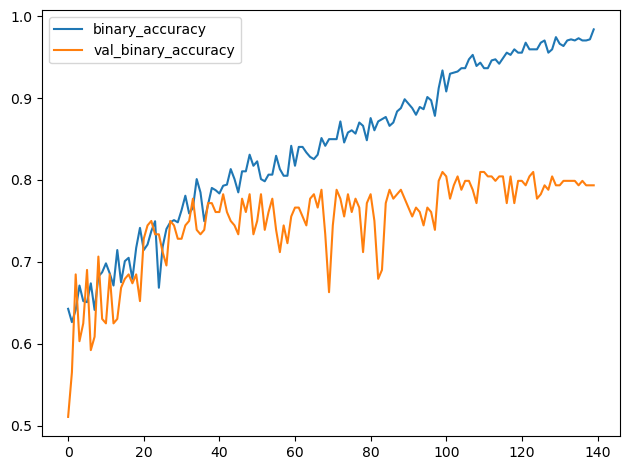

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot()